# Experiments LSTM net

Here we tried to replicate the network that was used in [this](https://www.nature.com/articles/s41598-018-33321-1#Sec2) paper. But instead of using GRU we used LSTM. 

In [2]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from itertools import product
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_loader.data_loader import PhageLoader

%matplotlib inline

## LSTM

In [3]:
class BasicLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_dim, sequence_length, batch_size, labset_dim=2, number_of_layers=1, bidirectional=True, device=torch.device("cpu")):
        super(BasicLSTM, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.num_layers = number_of_layers
        self.device = device
        
        hidden_dim_dense = hidden_dim
        if bidirectional:
            hidden_dim_dense = hidden_dim * 2
        
        self.kmer2embedding = nn.Embedding(vocab_size, embedding_size)
        self.lstm = nn.LSTM(embedding_size, hidden_dim ,bidirectional=bidirectional,num_layers=number_of_layers)
        self.dense = nn.Linear(hidden_dim_dense, labset_dim)        


    def forward(self, sequence):
        # Input (shape: )
        #print(sequence.shape)
        #print(sequence)
        embedded_kmers = self.kmer2embedding(sequence)

        # embeddings -> LSTM hiddens (seq_len, batch, num_directions * hidden_size)
        out_lstm, _ = self.lstm(embedded_kmers.view(self.sequence_length, self.batch_size, -1)) 

        # LSTM hiddens -> dense layer 
        out_dense = self.dense(out_lstm.view(-1, self.hidden_dim*2))

        # dense layer -> probabilities
        out_log = F.log_softmax(out_dense, dim = 1)
        return out_log
    
    # Not being used for now
    def initHidden(self, batch_size, hidden_size):
        if self.bidirectional:
            return torch.zeros(self.num_layers*2, batch_size, hidden_size, device=this.device)
        else:
            return torch.zeros(self.num_layers, batch_size, hidden_size, device=this.device)
        
    # Not being used for now
    def create_emb_layer(self, weights_matrix, non_trainable=False):
        num_embeddings, embedding_dim = weights_matrix.size()
        emb_layer = nn.Embedding(num_embeddings, embedding_dim)
        emb_layer.load_state_dict({'weight': weights_matrix})
        if non_trainable:
            emb_layer.weight.requires_grad = False
            
        return emb_layer, num_embeddings, embedding_dim

In [4]:
# Setting up for working with GPU, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [5]:
# parameters for grid search
window_sizes = [1] # [1, 3, 5, 7]
strides = [1] # [1, 2]
batch_sizes = [30] # [30, 60, 120] 
embedding_layer_sizes = [4] # [50, 100]
hidden_layer_sizes = [30] # [30, 50, 80]
epochs_values = [15] # [10, 50, 100]
optimizers = ['SGD']#['SGD', 'ADAM']
learning_rates = [0.1] # [0.1, 0.01, 0.001] 

# other important parameters
#VOCAB_SIZE = len(kmers_dict)
LABSET_DIM = 2
BIDIRECTIONAL = True
sequence_length = 100
genomes_to_use = 'all' # len(loaders) for all genomes

In [6]:
# get dataset
loader = PhageLoader("data/")

In [7]:
from itertools import product

hyperparams_configs = list(product(window_sizes, \
                                   strides, batch_sizes, \
                                   embedding_layer_sizes, \
                                   hidden_layer_sizes, \
                                   epochs_values, \
                                   optimizers, \
                                   learning_rates))
hyperparams_configs

[(1, 1, 30, 4, 30, 15, 'SGD', 0.1)]

In [7]:
# Here just to speed up prototyping but it should be inside the loop
#experiment_loader = loader.get_data_loader(n='all',read_length=sequence_length, batch_size=30, k=3, stride=1, embedding="dict", embed_size=None, drop_last=False)
dataset = loader.get_data_set(n_files=genomes_to_use,read_length=sequence_length, batch_size=30, k=3, stride=1, embedding="dict", embed_size=None, drop_last=False)
# n -> how many files to bring
# read_length -> length of the sequence to read (in terms of number of k-mers)
# batch_size -> number of rows to recieve of length "read_length"
# k -> k-mer k
# stride -> stride for the kmer read
# embedding: "dict" to return a dictionary with the combinations of letters

In [ ]:
# TRAIN
# Set up the experiment 

print('DATA loading ...')
dataset = loader.get_data_set(n_files=genomes_to_use,read_length=sequence_length, batch_size=1, k=window_sizes[0], stride=1, embedding="dict", embed_size=None, drop_last=False)
train_sampler, valid_sampler, test_sampler = split_sets(dataset)
print('DATA loaded')

for (window_size, stride, batch_size, embedding_layer_size, hidden_layer_size, epochs, optimizer_name, learning_rate) in hyperparams_configs:
    
    print('Running experiment with (window_size = %s, stride = %s, batch_size = %s, embedding_layer_size = %s, hidden_layer_size = %s, epochs = %s, optimizer = %s, learning_rate = %s)' % (window_size, stride, batch_size, embedding_layer_size, hidden_layer_size, epochs, optimizer_name, learning_rate))
    
    train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler,drop_last=True)
    validation = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                        sampler=valid_sampler,drop_last=True)
    test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                        sampler=test_sampler,drop_last=True)
    
    VOCAB_SIZE = 4**window_size
    
    basicLSTM = BasicLSTM(vocab_size = VOCAB_SIZE, \
              embedding_size = embedding_layer_size, \
              hidden_dim = hidden_layer_size,\
            sequence_length = 100, \
            batch_size = batch_size, \
              labset_dim= LABSET_DIM,\
              number_of_layers = 1, \
              bidirectional=BIDIRECTIONAL, \
              device=device)
    
    basicLSTM.to(device) # will move to cuda if available
    loss_function = nn.NLLLoss()
    optimizer = optim.SGD(basicLSTM.parameters(), lr=learning_rate)
    if optimizer_name == 'ADAM':
        pass # use ADAM

    # For the reports
    losses = []
    running_loss = 0
    tn = [] 
    fp = [] 
    fn = [] 
    tp = []
    e_running_loss = [] 
    dataset_type = [] 
    epochs_ids = []


    for epoch in range(epochs):

            # Iterate over all the training set
            for b, (x, y) in enumerate(train):

                basicLSTM.zero_grad()                    
                x = x.type(torch.LongTensor)
                y = y.type(torch.LongTensor)
                x, y = x.to(device), y.to(device)
                if y.size()[0] != batch_size:
                    break

                out = basicLSTM(x)  
                y = y.view(batch_size*sequence_length)
                out = out.view(batch_size*sequence_length,2)
                loss = loss_function(out, y)
                losses.append(loss.item())

                loss.backward()
                optimizer.step()

                # print statistics
                running_loss += loss.item()
                if b % 100 == 99:
                #if i % 2000 == 1999:    # print every 2000 mini-batches
                    #check_gradients(basicLSTM)
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, b + 1, running_loss / 2000))
                    running_loss = 0.0
        
            # Compute metrics for each epoch

            epochs_ids.append(epoch); epochs_ids.append(epoch);
            e_running_loss.append(running_loss); e_running_loss.append(running_loss);

            nb_classes = 2

            # Metrics on training set
            tn_e, fp_e, fn_e, tp_e = get_confusion_matrix(basicLSTM, train)
            tn.append(tn_e); fp.append(fp_e); fn.append(fn_e); tp.append(tp_e);
            dataset_type.append('train')
            
            # Metrics on validation set
            tn_e, fp_e, fn_e, tp_e = get_confusion_matrix(basicLSTM, validation)
            tn.append(tn_e); fp.append(fp_e); fn.append(fn_e); tp.append(tp_e);
            dataset_type.append('validation')
            
    experiment_report = pd.DataFrame({'epoch': epochs_ids,\
                                     'running_loss': e_running_loss,\
                                     'dataset_type': dataset_type,\
                                     'tn': tn,\
                                     'fp': fp,\
                                     'fn': fn,\
                                     'tp': tp})
    experiment_report['accuracy'] = experiment_report.apply(lambda row: (row.tp + row.tn)/(row.tp + row.tn + row.fp + row.fn),axis=1)
    report_file_name = '%s-%s-%s-%s-%s-%s-%s-%s-%s' % (sequence_length, window_size, stride, batch_size, embedding_layer_size, hidden_layer_size, epochs, optimizer_name, learning_rate)
    experiment_report.to_csv('experiments_reports/%s.csv' % report_file_name)
        

DATA loading ...


In [141]:
experiment_report = pd.DataFrame({'epoch': epochs_ids[1:16],\
                                     'running_loss': e_running_loss[1:16],\
                                     'dataset_type': dataset_type[1:16],\
                                     'tn': tn[1:16],\
                                     'fp': fp[1:16],\
                                     'fn': fn[1:16],\
                                     'tp': tp[1:16]})

It took 25 minutes with 10 genomes and 10 epochs. 

In [142]:
experiment_report['accuracy'] = experiment_report.apply(lambda row: (row.tp + row.tn)/(row.tp + row.tn + row.fp + row.fn),axis=1)
experiment_report

,epoch,running_loss,dataset_type,tn,fp,fn,tp,accuracy
0,0,2.519275,validation,0.0,41366.0,0.0,372634.0,0.900082
1,1,3.669087,train,0.0,319561.0,0.0,3010439.0,0.904036
2,1,3.669087,validation,0.0,41302.0,0.0,372698.0,0.900237
3,2,2.922885,train,0.0,319311.0,0.0,3010689.0,0.904111
4,2,2.922885,validation,0.0,41334.0,0.0,372666.0,0.900159
5,3,3.315944,train,0.0,319231.0,0.0,3010769.0,0.904135
6,3,3.315944,validation,0.0,41463.0,0.0,372537.0,0.899848
7,4,2.908446,train,0.0,319310.0,0.0,3010690.0,0.904111
8,4,2.908446,validation,0.0,41238.0,0.0,372762.0,0.900391
9,5,3.245410,train,0.0,319334.0,0.0,3010666.0,0.904104


In [126]:
# Number of trainable parameters of pytorch model
#pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params = sum(p.numel() for p in basicLSTM.parameters() if p.requires_grad)
pytorch_total_params

23002

In [3]:
experiment_report = pd.read_csv('experiments_reports/100-3-1-30-50-30-10-SGD-0.1.csv')
experiment_report

,Unnamed: 0,epoch,running_loss,dataset_type,tn,fp,fn,tp,accuracy
0,0,0,2.519275,validation,0.0,41366.0,0.0,372634.0,0.900082
1,1,1,3.669087,train,0.0,319561.0,0.0,3010439.0,0.904036
2,2,1,3.669087,validation,0.0,41302.0,0.0,372698.0,0.900237
3,3,2,2.922885,train,0.0,319311.0,0.0,3010689.0,0.904111
4,4,2,2.922885,validation,0.0,41334.0,0.0,372666.0,0.900159
5,5,3,3.315944,train,0.0,319231.0,0.0,3010769.0,0.904135
6,6,3,3.315944,validation,0.0,41463.0,0.0,372537.0,0.899848
7,7,4,2.908446,train,0.0,319310.0,0.0,3010690.0,0.904111
8,8,4,2.908446,validation,0.0,41238.0,0.0,372762.0,0.900391
9,9,5,3.245410,train,0.0,319334.0,0.0,3010666.0,0.904104


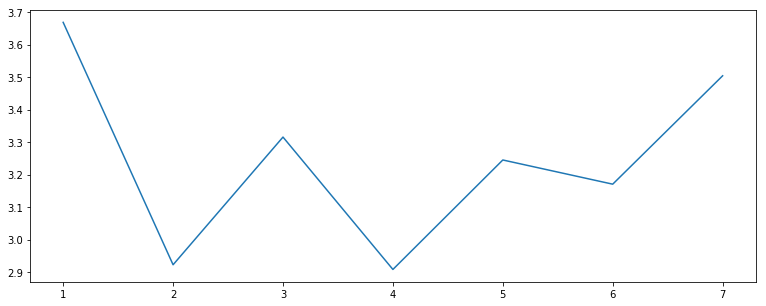

In [12]:
#losses
plt.figure(figsize=(13,5))
#sns.lineplot(x=range(len(losses)),y=losses)
sns.lineplot(x=experiment_report[experiment_report.dataset_type=='train'].epoch.values, y=experiment_report[experiment_report.dataset_type=='train'].running_loss.values)
# experiment_report.running_loss.values

In [146]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
classes = {0: 'inter-genic', 1: 'genic'}

with torch.no_grad():
    for i, (raw_kmer, raw_labels) in enumerate(test):
        kmer = prepareSequence(raw_kmer, kmers_dict)
        labels = torch.tensor(raw_labels)
        out = basicLSTM(labels)
        _, predicted = torch.max(out, 1)
        c = (predicted == labels).squeeze()
        for i in range(1):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of inter-genic : 100 %
Accuracy of genic :  0 %


In [145]:
?torch.Tensor.squeeze

Docstring:
squeeze(dim=None) -> Tensor

See :func:`torch.squeeze`
Type:      method_descriptor


## Extra functions

In [9]:
# Returns a sampler for each set of the design set
def split_sets(dataset):
    n = len(dataset)  # how many total elements you have
    test_size = .1
    n_test = int( n * test_size )  # number of test/val elements
    n_train = n - 2 * n_test

    idx = list(range(n))  # indices to all elements
    np.random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
    train_idx = idx[:n_train]
    val_idx = idx[n_train:(n_train + n_test)]
    test_idx = idx[(n_train + n_test):]

    print(n,len(train_idx),len(val_idx),len(test_idx))
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    return train_sampler, valid_sampler, test_sampler

In [10]:
train, validation, test = split_sets(dataset, 30)

NameError: name 'dataset' is not defined

In [11]:
# [[y0 and pred0 (), y0 and pred1 ()]
# [y1 and pred0 (), y1 and pred1 (TP)]]]
def get_confusion_matrix(model, dataset):
    y_lists = []
    preds_lists = []
    confusion_matrix_manual = torch.zeros(2, 2)
    with torch.no_grad():
        for i, (x, y) in enumerate(dataset):
            x = x.type(torch.LongTensor)
            y = y.type(torch.LongTensor)
            x, y = x.to(device), y.to(device)
            out = model(x)
            _, preds = torch.max(out, 1)
            y_lists.append(y.view(-1).numpy())
            preds_lists.append(preds.view(-1).numpy())
            for t, p in zip(y.view(-1), preds.view(-1)):
                    confusion_matrix_manual[t.long(), p.long()] += 1

#     To compare with numpy
#     y_array = np.concatenate(y_lists)
#     preds_array = np.concatenate(preds_lists)
#     print(preds_array.shape)
#     print(preds_array)
#     sk_confusion = confusion_matrix(y_array, preds_array)

    
    tn, fp, fn, tp= confusion_matrix_manual.numpy().ravel()
    
    return (tn, fp, fn, tp)

In [12]:
def check_gradients(model):
    lstm = model.lstm
    for p,n in zip(lstm.parameters(),lstm._all_weights[0]):
        if n[:6] == 'weight':
            print('===========\ngradient:{}\n----------\n{}'.format(n,p.grad.abs().sum()))